# Setup of AAT observations

For each observation (which, in my case, corresponds to one cluster), we need to produce a single `.fld` file in the correct format.\
This file needs to include:

- The targets to observe (`members`) as the science targets
- White Dwarfs for spectroscopic calibration
- Guide stars
- Sky fibres

where the specification letter needs to provided with the sources.\
For more specific information, please see the `README.md` file.

## Requirements

For this script to work, the following packages need to be installed:

- `astropy`
- `astroquery`
- Standard modules like `numpy`, `scipy` (for the matching algorithm of astropy), and `matplotlib`
  
Also, a python version $>$ 3.9 is recommended, but not entirely necessary (with earlier versions, you might need to replace some types in the type hints with imports from the `typing` module, e. g. replace `tuple[str, str]` with `Tuple[str, str]` and include `from typing import Tuple` in the header.)

In [129]:
from typing import Literal
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import SkyCoord
import aat_clusters_scripts as acs


In [ ]:
# For my use case, I am looking at clusters.
ALL_CLUSTERS = Table.read(acs.PATHS.clusters)

## Full run for all sources

The following cell specifies the parameters for the run and performs it for all observations:

In [116]:
VERBOSE = False
GUIDE_R_MIN = 14.0
GUIDE_R_MAX = 14.5
GUIDE_PM_MAX = 50

TARGET_CONTAINERS = []
for cluster in ALL_CLUSTERS:
    # Specify the type of ID, ra, and dec for each observation:
    cluster_id, ra, dec = cluster[["mem_match_id", "ra_corr", "dec_corr"]]

    target_container = acs.TargetContainer(cluster_id, ra, dec, selection_radius=1.)
    target_container.get_cluster_members(verbose=VERBOSE)
    target_container.get_agn(verbose=VERBOSE)
    target_container.get_white_dwarfs(verbose=VERBOSE)
    target_container.get_guide_stars(GUIDE_R_MIN, GUIDE_R_MAX, GUIDE_PM_MAX, verbose=VERBOSE)
    target_container.get_sky_fibres(verbose=VERBOSE)
    target_container.write_targets_to_disc()
    target_container.pprint()
    TARGET_CONTAINERS.append(target_container)

[-2060224498] at [180.82°, -21.57°] with 745 total objects.
	cluster_members   -> 184 sources
	agn_candidates    -> 251 sources
	white_dwarfs      -> 10 sources
	guide_stars       -> 150 sources
	sky_fibres        -> 150 sources
[-879663103] at [168.71°, -12.23°] with 639 total objects.
	cluster_members   -> 141 sources
	agn_candidates    -> 188 sources
	white_dwarfs      -> 10 sources
	guide_stars       -> 150 sources
	sky_fibres        -> 150 sources
[-1855905442] at [223.12°, -24.45°] with 548 total objects.
	cluster_members   -> 71 sources
	agn_candidates    -> 167 sources
	white_dwarfs      -> 10 sources
	guide_stars       -> 150 sources
	sky_fibres        -> 150 sources


In [118]:
for target_container in TARGET_CONTAINERS:
    fig, ax = plt.subplots(figsize=(8, 8))
    target_container.plot_sources_on_ax(ax, alpha=0.6, marker=".", s=20)
    fname = f"./data/plots/positional_plot_{target_container.container_id}.png"
    fig.savefig(fname)
    print(f"Saved a positional plot of the sources at {fname}.")
    plt.close()

Saved a positional plot of the sources at ./data/plots/positional_plot_-2060224498.png.
Saved a positional plot of the sources at ./data/plots/positional_plot_-879663103.png.
Saved a positional plot of the sources at ./data/plots/positional_plot_-1855905442.png.


## Perform some visual inspection

The following cells can be used to get a feeling for the distribution of the sources, and to look at some of them in the SkyViewer.

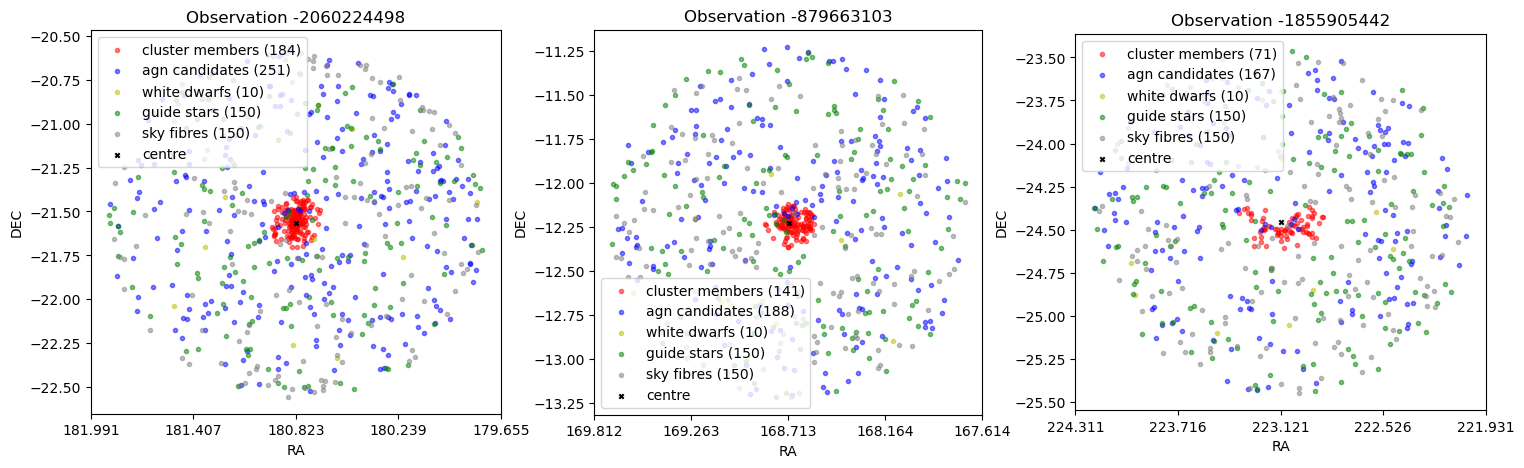

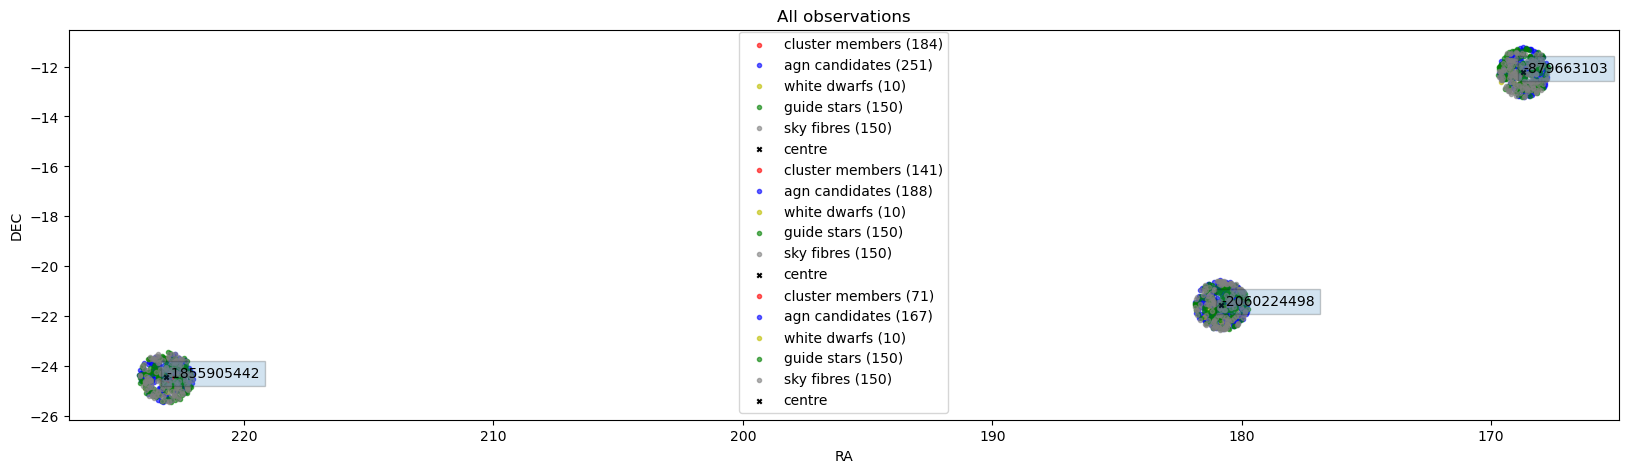

In [119]:
from matplotlib.ticker import LinearLocator
num_plots = len(TARGET_CONTAINERS)
fig, axes = plt.subplots(1, num_plots, figsize=(5*num_plots, 5))
for ax, container in zip(axes, TARGET_CONTAINERS):
    container.plot_sources_on_ax(ax, alpha=0.5, marker=".")
    ax.xaxis.set_major_locator(LinearLocator(5))
    # ax.margins(-0.1)  # To zoom in
fig, ax = plt.subplots(figsize=(20, 20))
for container in TARGET_CONTAINERS:
    container.plot_sources_on_ax(ax, alpha=0.6, marker=".")
    ax.set_title("All observations")
    ax.annotate(container.container_id, (container.obs_ra, container.obs_dec), bbox=dict(alpha=0.2))

In [120]:
container_for_inspection: acs.TargetContainer = TARGET_CONTAINERS[0]

### Looking at the targets in the legacy survey

To look at the different object types, change the "table_to_inspect" to the one of your choice.\
You can vary whether just the first ones or a random selection are displayed.

In [150]:
def get_selection(target_container: acs.TargetContainer,
                  table_name: str,
                  selection_mode: Literal["first_few", "random"] = "random",
                  num_objects=1) -> Table:
    table = target_container[table_name]
    if selection_mode == "random":
        # To look at some random objects:
        return np.random.choice(table, num_objects)
    else: 
        return table[:num_objects]




# ! Specify which  and how many sources to look at
# possible_tables = ['cluster_members', 'agn_candidates', 'white_dwarfs', 'guide_stars', 'sky_fibres']
table_name = "sky_fibres"
selection_mode = "random"
num_objects = 1

selection = get_selection(container_for_inspection, table_name, selection_mode, num_objects)
for target in selection:
    url = acs.get_legacysurvey_url(target["ra"], target["dec"])
    print(url)
    name, ra, dec, mag_r = target[["obj_name", "ra", "dec", "rmag"]]
    print(f"{name = }, {ra = :.4f}, {dec = :.4f}, {mag_r = :.1f} [from {table_name}]")
    acs.display_html_site(url)

https://www.legacysurvey.org/viewer?ra=181.517602364031&dec=-20.983028766269644&layer=ls-dr10&zoom=14&mark=181.517602364031,-20.983028766269644
name = 'skyfibre_099', ra = 181.5176, dec = -20.9830, mag_r = 30.0 [from sky_fibres]
